In [59]:
#imports
import torch 
import torchio as tio
from torch.utils.data import DataLoader
import pydicom
import os
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
# Function that will randomly split my data into 2 categories: training and testing 
# The validation set will be taken directly from the training set
def random_split(subjects, ratio=0.9):
    num_subjects = len(subjects)
    num_training_subjects = int(ratio * num_subjects)
    num_test_subjects = num_subjects - num_training_subjects

    num_split_subjects = num_training_subjects, num_test_subjects
    return torch.utils.data.random_split(subjects, num_split_subjects)



def Create_dataset(rootdir):
    file_paths = []
    subject_paths = []
    subjects_list = []
    nb_subjects = 0
    
    # Start by recovering the path to the subjects
    for subjects in os.listdir(rootdir):
        subject_path = os.path.join(rootdir,subjects)
        subject_paths.append(subject_path)
        nb_subjects += 1
    
   
    for subject_path in subject_paths:
        # Recover all the files
        ct_path = None
        mri_path = None
        
        transform_canonical = tio.ToCanonical()
        
        for subfolder in os.listdir(subject_path):
            subfolder_path= os.path.join(subject_path,subfolder)
            if subfolder.startswith('CT'):
                ct_path = subfolder_path
            elif subfolder.startswith('IRM'):
                mri_path = subfolder_path
        
            
        # Create the subject format of torchio witht the scans and the id of the patient
        sub = tio.Subject(
            CT = tio.ScalarImage(ct_path),
            MRI = tio.ScalarImage(mri_path),
            id_patient = os.path.basename(subject_path),

        ) 
        sub= transform_canonical(sub)
        subjects_list.append(sub)
        
    # List of transforms : for training, possibility of data augmentation!
    # Careful when rescaling intensity with multiple images (t1,t2...), use include to select one type of image
    transforms_train = [
        tio.Clamp(out_min=0,out_max = 2500),
        tio.RescaleIntensity(out_min_max=(0, 1)),
        #tio.RescaleIntensity(out_min_max=(0, 1), include=(['CT'])),
        #tio.RescaleIntensity(out_min_max=(0, 1), include=(['IRM'])),
        #tio.RandomFlip(p=0.2), #data augmentation
        #tio.RandomAffine(scales=(0.9, 1.2), degrees=15, p=0.2),  #data augmentation
        tio.Resample('MRI'),

    ]

   
    

    # Create our own set of tranforms that we will apply to our dataset
    transfo_tr = tio.Compose(transforms_train)
    

    
    dataset = tio.SubjectsDataset(subjects_list, transform = transfo_tr)
    #print('Dataset successfully created! The set is made of',nb_subjects,'patients.')
    print('Datasets successfully created!')
    print('=======================================================')
    print(' Dataset is made of', len(dataset), 'images') 
    print('=======================================================')
    ids = [subject.id_patient for subject in dataset.dry_iter()]
    
    return dataset


dataset = Create_dataset('../Clara intern/whole body')

Datasets successfully created!
 Dataset is made of 1 images


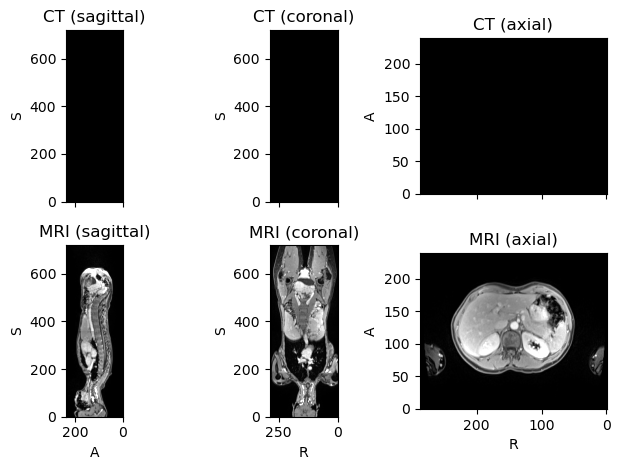

In [102]:
dataset[0].plot()

Voxel spacing (in mm): (1.3889000415802002, 1.3889000415802002, 1.399999976158142)


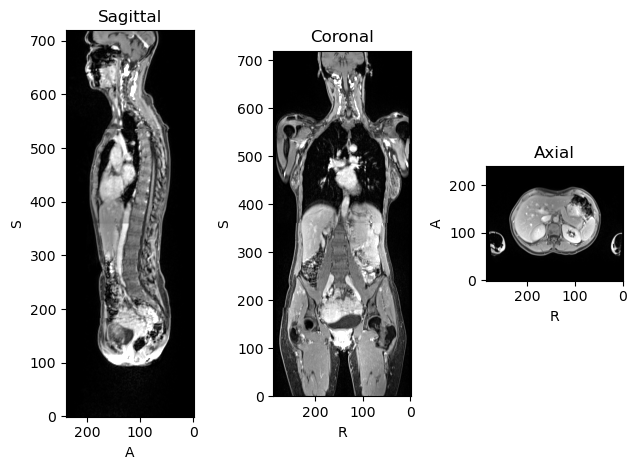

In [72]:
import torchio as tio
nifti_file_path = '/home/radiology/Clara intern/t1_vibe_dixon_tra_p4_bh_iso_Gd_3_45001.nii.gz'


image = sitk.ReadImage(nifti_file_path)

spacing = image.GetSpacing()

print("Voxel spacing (in mm):", spacing)

# Define your transforms
transforms_train = [
    tio.ToCanonical(),                          # Ensures the image is in canonical orientation
    tio.Clamp(out_min=0, out_max=2500),         # Clamps the intensity values
    tio.RescaleIntensity(out_min_max=(0, 1)),   # Rescales intensity values
    #tio.RandomFlip(p=0.2),                     # Data augmentation: Random flip with probability 0.2
    #tio.RandomAffine(scales=(0.9, 1.2), degrees=15, p=0.2),  # Data augmentation: Random affine transformation
    tio.Resample((1.3889000415802002, 1.3889000415802002, 1.399999976158142)), # Resample based on voxel size
]

# Load the image using torchio
image = tio.ScalarImage(nifti_file_path)

# Apply the transforms
transformed_image = tio.Compose(transforms_train)(image)
transformed_image.plot()
# Save or use the transformed image
#ransformed_image.save('/home/radiology/Clara Intern/transformed_image.nii.gz')


In [6]:
# UNIFORM sampler
# Chose the sampler for your data
patch_size = (64,64,8)
sampler = tio.data.UniformSampler(patch_size)

In [7]:
samples_per_volume=4
max_length=200 
num_workers=8


patches_dataset = tio.Queue(
        subjects_dataset=dataset,
        max_length=max_length, # Maximum number of patches that can be stored in the queue
        samples_per_volume=samples_per_volume, # Number if patches to be extracted from each volume
        sampler=sampler, # The sampler that we defined previously
        num_workers=num_workers, # Number of subprocesses to use for data loading
        shuffle_subjects=True,
        shuffle_patches=True,
    )


# Define loader, no need to shuffle it as the queue already does it
loader_patches = DataLoader(
    patches_dataset,
    batch_size = 16,
    num_workers = 0, # Need to instianciate it to 0 for Loaders
    drop_last = True,
)


ImageSeriesReader (0x8684380): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.49588

ImageSeriesReader (0x8684380): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.39416



In [16]:
import itk
from itkwidgets import compare, checkerboard
import numpy as np
import os
import SimpleITK as sitk
import sys

In [83]:
import SimpleITK as sitk
import os

def convert_dicom_series_to_mha(dicom_folder, output_file):
    reader = sitk.ImageSeriesReader()

    dicom_names = reader.GetGDCMSeriesFileNames(dicom_folder)
    
    if not dicom_names:
        print(f"No DICOM files found in {dicom_folder}")
        return

    reader.SetFileNames(dicom_names)
    
    image = reader.Execute()
    
    sitk.WriteImage(image, output_file)
    print(f"Converted {dicom_folder} to {output_file}")

def convert_all_dicom_folders(base_directory, output_directory):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    for folder_name in os.listdir(base_directory):
        folder_path = os.path.join(base_directory, folder_name)
        
        if os.path.isdir(folder_path):
            output_file = os.path.join(output_directory, f"{folder_name}.mha")
            convert_dicom_series_to_mha(folder_path, output_file)
            

base_directory = '../Clara intern/whole body/trunk'
output_directory = '../Clara intern/elastix_data'
convert_all_dicom_folders(base_directory, output_directory)

Converted ../Clara intern/whole body/trunk/CT_trunk to ../Clara intern/elastix_data/CT_trunk.mha
Converted ../Clara intern/whole body/trunk/IRM_trunk to ../Clara intern/elastix_data/IRM_trunk.mha


In [125]:
import SimpleITK as sitk


def resample_image(input_image_path, reference_image_path, output_image_path):
    # Read the images
    input_image = sitk.ReadImage(input_image_path)
    reference_image = sitk.ReadImage(reference_image_path)

    # Define the resampler
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(reference_image.GetSize())
    resampler.SetOutputSpacing(reference_image.GetSpacing())
    resampler.SetOutputOrigin(reference_image.GetOrigin())
    resampler.SetOutputDirection(reference_image.GetDirection())
    resampler.SetDefaultPixelValue(0)  # This should be suitable for your data type

    # Set the resampling parameters
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)  # Ensure this is appropriate for your image

    # Perform the resampling
    resampled_image = resampler.Execute(input_image)

    # Save the resampled image
    sitk.WriteImage(resampled_image, output_image_path)
    
# Paths to images
input_image_path = '../Clara intern/elastix_data/CT_trunk.mha'
reference_image_path = '../Clara intern/elastix_data/IRM_trunk.mha'
output_image_path = '../Clara intern/elastix_data/CT_trunk_resampled.mha'

# Resample the image
resample_image(input_image_path, reference_image_path, output_image_path)



Image min: -3024
Image max: 2011
Image mean: -1187.0583906567786


In [119]:
import SimpleITK as sitk
import subprocess

def read_image(file_path):
    import SimpleITK as sitk
    return sitk.ReadImage(file_path, sitk.sitkFloat32)

def write_image(image, file_path):
    import SimpleITK as sitk
    sitk.WriteImage(image, file_path)

def register_images(fixed_image_path, moving_image_path, parameter_file, output_directory):

    fixed_image = read_image(fixed_image_path)
    moving_image = read_image(moving_image_path)
    

    fixed_image_path_quoted = f'"{fixed_image_path}"'
    moving_image_path_quoted = f'"{moving_image_path}"'
    parameter_file_quoted = f'"{parameter_file}"'
    output_directory_quoted = f'"{output_directory}"'
    
    elastix_command = (f'elastix -f {fixed_image_path_quoted} '
                       f'-m {moving_image_path_quoted} '
                       f'-p {parameter_file_quoted} '
                       f'-out {output_directory_quoted}')
    
    try:
        subprocess.run(elastix_command, shell=True, check=True)
    except subprocess.CalledProcessError as e:
        print(f'Error running Elastix command: {e}')
        print(f'Command: {elastix_command}')
        raise

fixed_image_path = '../Clara intern/elastix_data/IRM_trunk.mha'
moving_image_path = '../Clara intern/elastix_data/CT_trunk.mha'
parameter_file = '../Clara intern/elastix_data/parameters.txt'
output_directory = '../Clara intern/elastix_data/'

register_images(fixed_image_path, moving_image_path, parameter_file, output_directory)



elastix is started at Wed Aug 14 15:30:52 2024.

which elastix:   elastix
  elastix version: 5.2.0
  Git revision SHA: ebb429a33bdf3248c2137fc4adb4259a2ec7db24
  Git revision date: Thu Jul 18 14:42:31 2024 +0200
  Build date: Jul 18 2024 12:58:48
  Compiler: GCC version 11.4.0
  Memory address size: 64-bit
  CMake version: 3.24.2
  ITK version: 5.4.0

Command-line arguments: 
  -f "../Clara intern/elastix_data/IRM_trunk.mha" -m "../Clara intern/elastix_data/result.mha" -p "../Clara intern/elastix_data/parameters_non_rigid.txt" -out "../Clara intern/elastix_data/"

elastix runs at: DATASC5
  Linux 6.5.0-1024-oem (x64), #25-Ubuntu SMP PREEMPT_DYNAMIC Mon May 20 14:47:48 UTC 2024
  with 31724 MB memory, and 12 cores @ 1251 MHz.
-------------------------------------------------------------------------

Running elastix with parameter file 0: "../Clara intern/elastix_data/parameters_non_rigid.txt".

Current time: Wed Aug 14 15:30:52 2024.
Reading the elastix parameters from file ...

Instal

28	-0.279052	0.000000	21410.179897	0.000545	5.0
29	-0.282779	0.000000	21410.179897	0.000524	4.7
30	-0.267708	0.000000	21410.179897	0.000566	4.4
31	-0.280149	0.000000	21410.179897	0.000638	4.9
32	-0.284356	0.000000	21410.179897	0.000538	4.5
33	-0.277659	0.000000	21410.179897	0.000592	4.8
34	-0.284784	0.000000	21410.179897	0.000544	4.5
35	-0.280515	0.000000	21410.179897	0.000559	4.3
36	-0.291667	0.000000	21410.179897	0.000594	4.5
37	-0.287811	0.000000	21410.179897	0.000527	4.8
38	-0.296139	0.000000	21410.179897	0.000587	5.0
39	-0.291890	0.000000	21410.179897	0.000580	4.5
40	-0.290734	0.000000	21410.179897	0.000571	4.6
41	-0.291122	0.000000	21410.179897	0.000578	4.7
42	-0.313335	0.000000	21410.179897	0.000644	4.5
43	-0.302644	0.000000	21410.179897	0.000634	4.7
44	-0.304859	0.000000	21410.179897	0.000643	4.9
45	-0.313858	0.000000	21410.179897	0.000556	4.7
46	-0.319202	0.000000	21410.179897	0.000599	4.7
47	-0.329445	0.000000	21410.179897	0.000554	4.3
48	-0.314648	0.000000	21410.179897	0.000

215	-0.452199	14.064884	12822.337513	0.000738	3.2
216	-0.459865	15.064884	12466.802264	0.000590	3.3
217	-0.467849	16.014778	12146.872257	0.000714	3.2
218	-0.458414	17.014778	11827.341986	0.000611	3.1
219	-0.457031	16.464192	12001.160283	0.000601	3.5
220	-0.447090	15.913607	12180.163759	0.000655	3.4
221	-0.462241	16.913607	11858.902747	0.000654	3.2
222	-0.462491	16.363022	12033.656788	0.000724	3.2
223	-0.440297	15.813191	12213.387651	0.000753	3.2
224	-0.469203	15.262606	12398.826978	0.000698	3.3
225	-0.451443	14.756328	12574.383534	0.000691	3.3
226	-0.446909	14.205742	12771.035326	0.000626	3.2
227	-0.465664	13.655178	12973.927997	0.000643	3.2
228	-0.453720	13.104592	13183.379430	0.000705	3.2
229	-0.469356	12.554007	13399.704611	0.000733	3.7
230	-0.458949	13.554007	13011.914427	0.000657	3.4
231	-0.472150	14.295355	12738.610405	0.000720	3.4
232	-0.458024	13.744770	12940.473687	0.000696	3.3
233	-0.457403	13.633851	12981.917063	0.000662	3.3
234	-0.452011	13.083265	13191.628561	0.000676	3.3


403	-0.508279	26.651860	9435.387711	0.000712	3.0
404	-0.507614	27.645186	9242.718825	0.000775	3.1
405	-0.507243	28.645186	9056.543296	0.000661	3.0
406	-0.513523	29.645174	8877.722112	0.000641	3.4
407	-0.507489	30.644951	8705.861255	0.000732	3.3
408	-0.525045	30.094366	8799.674323	0.000722	2.9
409	-0.503825	31.094366	8630.756357	0.000644	2.9
410	-0.499928	31.952577	8490.876244	0.000676	2.9
411	-0.510320	32.945305	8334.622887	0.000688	3.0
412	-0.506093	32.396648	8420.262229	0.000700	3.0
413	-0.508597	33.396648	8265.468459	0.000734	2.9
414	-0.510501	34.396648	8116.263249	0.000845	3.0
415	-0.499623	33.846143	8197.728260	0.000680	3.0
416	-0.503560	34.846143	8050.936968	0.000658	3.0
417	-0.516291	34.295558	8131.101244	0.000605	3.0
418	-0.506113	33.744972	8212.877992	0.000733	2.8
419	-0.506132	33.194387	8296.316350	0.000691	2.8
420	-0.505233	32.643801	8381.467491	0.000659	2.9
421	-0.509491	32.093216	8468.384694	0.000742	2.9
422	-0.510217	31.543093	8557.048136	0.000738	2.9
423	-0.502128	30.992

Initialization of AdvancedMattesMutualInformation metric took: 911 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 2.118450s
  NumberOfGradientMeasurements to estimate sigma_i: 2
  Sampling gradients ...
  Sampling the gradients took 0.042979s
Automatic parameter estimation took 2.16s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.452158	0.000000	26820.860044	0.000914	3076.7
1	-0.470661	0.000000	26820.860044	0.001024	3.0
2	-0.465314	0.000000	26820.860044	0.001068	2.9
3	-0.459960	0.000000	26820.860044	0.001052	3.1
4	-0.480339	0.000000	26820.860044	0.001068	3.3
5	-0.474895	1.000000	25601.730042	0.001093	3.2
6	-0.476524	0.206561	26559.613312	0.001116	3.1
7	-0.467371	0.000000	26820.860044	0.001094	3.0
8	-0.474460	0.000000	26820.860044	0.001046	3.2
9	-0.480832	0.000000	26820.860044	0.001160	2.9
10	-0.480018	0.000000	26820.8

182	-0.561904	53.614699	7548.620703	0.001157	2.9
183	-0.571130	54.614699	7448.790633	0.001233	3.1
184	-0.560141	53.821260	7527.781025	0.001212	3.3
185	-0.563659	54.821260	7428.497776	0.001313	3.0
186	-0.565882	54.027821	7507.056096	0.001207	3.1
187	-0.561680	53.234382	7587.293724	0.001219	3.1
188	-0.574433	54.145108	7495.338990	0.001128	3.1
189	-0.564931	55.145108	7396.904052	0.001157	3.1
190	-0.568242	54.351669	7474.792066	0.001182	3.3
191	-0.565706	55.333038	7378.693119	0.001269	3.2
192	-0.559139	54.553331	7454.840890	0.001084	3.0
193	-0.563580	55.553331	7357.459877	0.001140	3.3
194	-0.576860	56.553331	7262.590195	0.001235	3.2
195	-0.577422	56.686568	7250.134403	0.001257	3.5
196	-0.572002	57.686568	7157.994999	0.001199	3.3
197	-0.558573	58.686221	7068.198960	0.001293	2.9
198	-0.553379	59.686221	6980.597894	0.001360	3.0
199	-0.561804	60.686221	6895.141646	0.001210	3.1
200	-0.560994	61.686165	6811.757011	0.001287	3.1
201	-0.566689	62.686165	6730.360557	0.001309	3.1
202	-0.576688	61.892

384	-0.595607	112.710425	4212.372086	0.001321	2.9
385	-0.586697	111.916986	4237.517556	0.001175	3.2
386	-0.582436	112.916986	4205.874687	0.001216	2.9
387	-0.598264	113.916986	4174.700891	0.001196	2.8
388	-0.581350	114.916986	4143.985813	0.001121	2.8
389	-0.593305	115.916986	4113.719402	0.001160	2.8
390	-0.588184	116.916986	4083.891898	0.001222	2.9
391	-0.586101	116.123547	4107.522551	0.001297	3.1
392	-0.596215	115.330108	4131.428264	0.001247	2.9
393	-0.588538	114.536669	4155.613865	0.001203	2.7
394	-0.582644	115.536669	4125.177983	0.001241	2.8
395	-0.584410	114.743230	4149.290250	0.001268	2.7
396	-0.579653	113.949791	4173.686053	0.001197	3.1
397	-0.589190	113.156352	4198.370423	0.001189	2.9
398	-0.590288	112.362913	4223.348512	0.001145	2.7
399	-0.588490	111.571644	4248.556051	0.001305	2.8
400	-0.600757	112.571644	4216.748731	0.001155	2.8
401	-0.607141	113.339001	4192.662279	0.001164	2.7
402	-0.592585	112.545569	4217.572054	0.001210	2.9
403	-0.584228	111.752130	4242.779830	0.001239	2.9


Initialization of AdvancedMattesMutualInformation metric took: 768 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 15.783702s
  NumberOfGradientMeasurements to estimate sigma_i: 2
  Sampling gradients ...
  Sampling the gradients took 0.077168s
Automatic parameter estimation took 15.86s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.510268	0.000000	34208.350351	0.001905	16637.8
1	-0.518721	0.000000	34208.350351	0.001571	6.9
2	-0.502144	0.999393	32654.326011	0.001688	6.9
3	-0.506808	1.999393	31234.535248	0.001809	7.0
4	-0.511938	2.999393	29933.063373	0.001737	7.0
5	-0.517711	3.975023	28763.751227	0.001640	7.0
6	-0.511466	3.185587	29702.622654	0.001647	6.8
7	-0.523097	4.185145	28523.772415	0.001676	6.9
8	-0.527651	4.378861	28306.051889	0.001718	6.8
9	-0.513498	5.378861	27232.993737	0.001608	6.9
10	-0.513712	4.494137	2817

158	-0.556583	79.205095	7169.050178	0.001795	7.6
159	-0.572354	78.320380	7232.909893	0.001783	7.1
160	-0.579575	79.320379	7160.811818	0.001950	7.2
161	-0.555166	80.320379	7090.136877	0.001862	7.3
162	-0.560692	81.320379	7020.843380	0.001854	7.1
163	-0.554536	82.120089	6966.395805	0.001847	7.0
164	-0.569653	83.120089	6899.488497	0.001931	7.1
165	-0.556298	84.120089	6833.854150	0.001996	7.1
166	-0.557459	83.235365	6891.858239	0.001869	6.8
167	-0.563472	84.235365	6826.368294	0.002064	6.8
168	-0.577534	83.350646	6884.244471	0.001852	6.8
169	-0.582026	84.350646	6818.898460	0.001883	6.6
170	-0.570604	85.350646	6754.781327	0.001883	6.7
171	-0.561322	86.061832	6709.910962	0.001811	6.8
172	-0.563835	87.061832	6647.817706	0.001870	6.7
173	-0.566209	86.177107	6702.694035	0.001876	6.7
174	-0.545886	87.177107	6640.733661	0.001813	6.7
175	-0.571821	88.177107	6579.908330	0.002165	6.9
176	-0.546497	89.177107	6520.187137	0.001733	6.9
177	-0.572132	90.177107	6461.540287	0.001950	6.8
178	-0.561122	89.292

339	-0.583470	159.219402	3986.115521	0.001908	6.9
340	-0.580190	158.444886	4003.320306	0.001964	7.0
341	-0.573421	159.444886	3981.134481	0.002052	7.5
342	-0.571002	160.426317	3959.598417	0.001854	6.7
343	-0.573058	161.426317	3937.893224	0.001932	7.2
344	-0.579084	162.426317	3916.424695	0.001825	6.5
345	-0.601168	163.426317	3895.188981	0.001934	6.7
346	-0.575751	164.426317	3874.182314	0.001881	6.6
347	-0.576509	165.423500	3853.459238	0.001921	6.6
348	-0.573971	166.423500	3832.899067	0.001929	6.6
349	-0.570121	165.538775	3851.077911	0.001799	6.5
350	-0.560149	166.538775	3830.543075	0.001839	6.6
351	-0.582250	165.654051	3848.699525	0.001905	6.6
352	-0.567948	166.654051	3828.189978	0.001867	6.5
353	-0.586175	167.654051	3807.897861	0.002069	6.6
354	-0.570451	168.654051	3787.819736	0.001897	6.4
355	-0.556228	168.993797	3781.046380	0.001866	6.5
356	-0.579472	168.109072	3798.735557	0.001980	6.6
357	-0.565855	169.109072	3778.753683	0.001930	6.5
358	-0.581581	168.590516	3789.089104	0.001733	6.7


Initialization of AdvancedMattesMutualInformation metric took: 815 ms.
Starting automatic parameter estimation for AdaptiveStochasticGradientDescent ...
  The default value "Original" is used instead.
  Computing JacobianTerms ...
  Computing the Jacobian terms took 2m28.908363s
  NumberOfGradientMeasurements to estimate sigma_i: 2
  Sampling gradients ...
  Sampling the gradients took 0.251628s
Automatic parameter estimation took 2m29.16s
1:ItNr	2:Metric	3a:Time	3b:StepSize	4:||Gradient||	Time[ms]
0	-0.506028	0.000000	58027.773027	0.002775	150029.1
1	-0.492566	0.000000	58027.773027	0.002726	44.5
2	-0.490160	1.000000	55390.147378	0.002631	46.5
3	-0.501504	2.000000	52981.880084	0.002738	46.2
4	-0.496173	3.000000	50774.301733	0.002587	46.2
5	-0.490048	4.000000	48743.329651	0.002635	45.8
6	-0.491651	4.999833	46868.887327	0.002869	45.1
7	-0.495235	5.999833	45132.991861	0.002756	45.8
8	-0.478264	6.999833	43521.089668	0.002479	45.3
9	-0.496847	7.999833	42020.353785	0.003015	44.7
10	-0.489401

154	-0.507576	71.283930	13204.717548	0.002694	43.7
155	-0.507350	72.283919	13063.165134	0.003025	43.8
156	-0.498438	73.283864	12924.621292	0.002682	42.2
157	-0.502744	74.283864	12788.977955	0.002844	43.0
158	-0.499801	75.283864	12656.152189	0.002533	42.4
159	-0.507345	76.283864	12526.057107	0.002647	43.8
160	-0.503594	77.283864	12398.609359	0.002418	43.9
161	-0.514739	78.283864	12273.728952	0.002556	42.3
162	-0.506166	79.283864	12151.339088	0.002698	42.5
163	-0.491676	78.385839	12261.135430	0.002694	42.7
164	-0.509040	79.385839	12138.995340	0.002728	44.4
165	-0.491894	78.487815	12248.567719	0.002668	43.6
166	-0.512656	78.353757	12265.094676	0.002615	42.9
167	-0.500955	79.353757	12142.876086	0.002540	43.3
168	-0.525196	80.353757	12023.069218	0.002736	42.4
169	-0.508975	79.479672	12127.659370	0.002654	43.6
170	-0.507748	80.479672	12008.151106	0.002851	43.6
171	-0.500446	80.049191	12059.307205	0.002659	42.6
172	-0.502871	81.049191	11941.135693	0.002351	42.5
173	-0.512060	82.049191	11825.2

319	-0.527206	130.929689	8020.705118	0.002905	43.7
320	-0.526547	131.929689	7968.258114	0.002759	44.2
321	-0.512915	132.929638	7916.495139	0.002927	42.9
322	-0.517194	133.929638	7865.397781	0.002808	42.6
323	-0.512789	134.929638	7814.955813	0.002903	42.7
324	-0.519477	134.031614	7860.224146	0.002651	43.8
325	-0.534474	133.371449	7893.838164	0.002631	43.5
326	-0.513523	132.473457	7940.025985	0.002512	42.5
327	-0.515998	131.576145	7986.721887	0.002586	42.6
328	-0.518373	132.576145	7934.716923	0.002547	42.9
329	-0.526312	132.154599	7956.556562	0.002733	44.1
330	-0.523876	133.154589	7904.942949	0.002668	42.8
331	-0.523820	132.972728	7914.279693	0.002629	43.3
332	-0.522449	133.972728	7863.210839	0.002909	42.3
333	-0.520929	134.972727	7812.796851	0.002851	42.6
334	-0.514667	135.916034	7765.829944	0.002536	43.1
335	-0.523507	135.018009	7810.529312	0.002659	44.0
336	-0.528247	136.017958	7760.788947	0.002654	42.2
337	-0.534432	137.017958	7711.675612	0.003099	42.8
338	-0.527834	138.017958	7663.1

484	-0.522821	180.552656	6045.979525	0.002989	44.8
485	-0.552990	179.654632	6073.038150	0.002782	44.5
486	-0.532205	180.654632	6042.922114	0.003015	44.7
487	-0.532118	181.654632	6013.103293	0.002933	44.6
488	-0.517066	182.654632	5983.577309	0.003011	44.6
489	-0.529907	182.689637	5982.548996	0.002905	45.4
490	-0.539302	183.689637	5953.321581	0.002840	45.3
491	-0.533455	184.678609	5924.696013	0.002934	44.2
492	-0.531593	183.956561	5945.568316	0.002970	44.4
493	-0.533023	183.058536	5971.733684	0.002633	45.5
494	-0.529670	184.042281	5943.082700	0.002733	45.5
495	-0.535967	183.174372	5968.345701	0.002684	44.6
496	-0.536843	184.174324	5939.257939	0.002774	44.9
497	-0.522371	185.173792	5910.466233	0.002694	44.5
498	-0.534721	186.173792	5881.937208	0.002831	44.3
499	-0.531294	187.173792	5853.682272	0.003192	47.6
Time spent in resolution 3 (ITK initialization and iterating): 172
Stopping condition: Maximum number of iterations has been reached.
Settings of AdaptiveStochasticGradientDescent in r

(288, 240, 451)


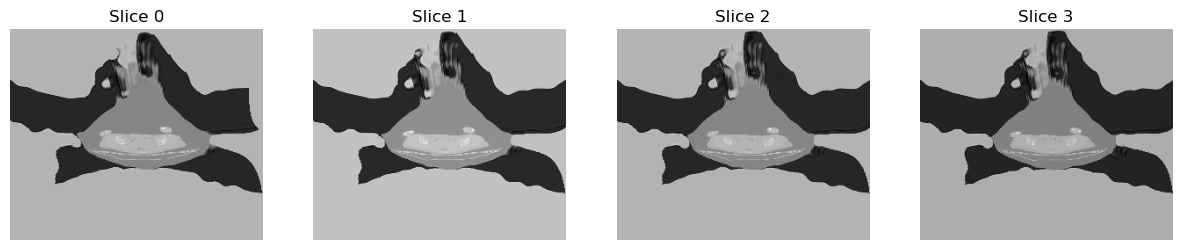

In [120]:
import SimpleITK as sitk
import matplotlib.pyplot as plt

def read_image(file_path):
    return sitk.ReadImage(file_path, sitk.sitkFloat32)
    
def display_slices(image_path, num_slices=4):
    image = sitk.ReadImage(image_path)
    print(image.GetSize())

    image_array = sitk.GetArrayFromImage(image)
    
    num_slices_available = image_array.shape[0]

    num_slices_to_display = min(num_slices, num_slices_available)
    
    fig, axes = plt.subplots(1, num_slices_to_display, figsize=(15, 5))
    
    for i in range(num_slices_to_display):
        slice_image = image_array[i, :, :]
        
        # Display the slice
        axes[i].imshow(slice_image, cmap='gray')
        axes[i].set_title(f'Slice {i}')
        axes[i].axis('off')  # Hide axis

    plt.show()

result_image_path = '../Clara intern/elastix_data/result.0.mhd'
display_slices(result_image_path, num_slices=4)

In [142]:
import SimpleITK as sitk
import os

def modify_image_information(image, new_origin, new_spacing):
    image.SetOrigin(new_origin)
    image.SetSpacing(new_spacing)
    return image

def process_dicom_folder(dicom_folder, output_folder, new_origin, new_spacing):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    dicom_series_reader = sitk.ImageSeriesReader()
    dicom_filenames = dicom_series_reader.GetGDCMSeriesFileNames(dicom_folder)
    dicom_series_reader.SetFileNames(dicom_filenames)
    
    image = dicom_series_reader.Execute()
    modified_image = modify_image_information(image, new_origin, new_spacing)
    
    output_file_path = os.path.join(output_folder, 'modified_IRM.nii.gz')
    sitk.WriteImage(modified_image, output_file_path)
    print(f"Saved modified image to {output_file_path}")


def convert_nii_to_mha(input_path, output_path):
    image = sitk.ReadImage(input_path)
    sitk.WriteImage(image, output_path)


dicom_folder = '../Clara intern/trunk/IRM_trunk'  
output_folder = '../Clara intern/trunk/IRM_trunk_resampled' 
output_final = '../Clara intern/trunk/IRM_trunk_resampled.mha'
out = '../Clara intern/trunk/IRM_trunk_resampled/modified_IRM.nii.gz'
new_origin = (0.0, 0.0, 0.0)  
new_spacing = (1.0, 1.0, 1.0)  
process_dicom_folder(dicom_folder, output_folder, new_origin, new_spacing)
convert_nii_to_mha(out, output_final)

Saved modified image to ../Clara intern/trunk/IRM_trunk_resampled/modified_IRM.nii.gz


MetaImageIO (0x20a213b0): Unsupported or empty metaData item ITK_FileNotes of type NSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEfound, won't be written to image file

MetaImageIO (0x20a213b0): Unsupported or empty metaData item aux_file of type NSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEfound, won't be written to image file

MetaImageIO (0x20a213b0): Unsupported or empty metaData item descrip of type NSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEfound, won't be written to image file

MetaImageIO (0x20a213b0): Unsupported or empty metaData item intent_name of type NSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEfound, won't be written to image file

MetaImageIO (0x20a213b0): Unsupported or empty metaData item qto_xyz of type N3itk6MatrixIfLj4ELj4EEEfound, won't be written to image file

